In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-covid19-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-covid19-pneumonia


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch


In [ ]:
print(os.listdir(path))

['Data']


In [ ]:
for root,dir,files in os.walk(path):
  print(root,"->",len(files))

/kaggle/input/chest-xray-covid19-pneumonia -> 0
/kaggle/input/chest-xray-covid19-pneumonia/Data -> 0
/kaggle/input/chest-xray-covid19-pneumonia/Data/test -> 0
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA -> 855
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL -> 317
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19 -> 116
/kaggle/input/chest-xray-covid19-pneumonia/Data/train -> 0
/kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA -> 3418
/kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL -> 1266
/kaggle/input/chest-xray-covid19-pneumonia/Data/train/COVID19 -> 460


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=c0bf6ad93a6c27ded116315780346cf343cb8d978f4c64f510ef402012e6f2be
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
import timm
import torch.nn as nn
from torchvision import models


In [ ]:
# Transforms for 224x224 models (ResNet, DenseNet, VGG, EfficientNet)
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Transforms for InceptionResNetV2 (299x299)
transform_299 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
base_dir = os.path.join(path,"Data","test")

In [ ]:
class LungSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.classes = ["COVID19","PNEUMONIA","NORMAL"]

        for label, cls in enumerate(self.classes):
            class_dir = os.path.join(root_dir, cls)
            if not os.path.exists(class_dir):
                print(f"⚠️ Warning: {class_dir} does not exist. Skipping.")
                continue
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((os.path.join(class_dir, img_file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

test_dataset_224 = LungSegmentationDataset(base_dir, transform=transform_224)
test_dataset_299 = LungSegmentationDataset(base_dir, transform=transform_299)

labels = [label for _, label in test_dataset_224.samples]
class_counts = Counter(labels)
print("Class counts:", {test_dataset_224.classes[k]: v for k, v in class_counts.items()})

# Compute weights (inverse frequency)
# Classes: 0=COVID19, 1=PNEUMONIA, 2=NORMAL
weights = [1.0 / class_counts[label] for label in labels]


use_oversampling = True

if use_oversampling:
    sampler = WeightedRandomSampler(weights, num_samples=3*max(class_counts.values()), replacement=True)
    shuffle_flag = False
else:
    sampler = None
    shuffle_flag = False

Class counts: {'COVID19': 116, 'PNEUMONIA': 855, 'NORMAL': 317}


In [ ]:
test_loader_224 = DataLoader(
    test_dataset_224,
    batch_size=32,
    shuffle=False,
    sampler=sampler,
    num_workers=2
)

test_loader_299 = DataLoader(
    test_dataset_299,
    batch_size=32,
    shuffle=False,
    sampler=sampler,
    num_workers=2
)

print("Classes:", test_dataset_224.classes)
print(f"Test images: {len(test_dataset_224)}")
print(f"Oversampling: {'ON' if use_oversampling else 'OFF'}")

Classes: ['COVID19', 'PNEUMONIA', 'NORMAL']
Test images: 1288
Oversampling: ON


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/Abnormality Detection Model"

EFFICIENTNET_PATH = os.path.join(DRIVE_PATH, "covidqu_model.pth")
RESNET_PATH       = os.path.join(DRIVE_PATH, "lung_segementation.pth")
DENSENET_PATH     = os.path.join(DRIVE_PATH, "densenet.pth")
VGG_PATH          = os.path.join(DRIVE_PATH, "vgg16_covid_final_best_model.pth")
INCEPTION_PATH    = os.path.join(DRIVE_PATH, "inceptionResNetV2.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
def load_models(device):
    # EfficientNet
    efficientnet = EfficientNet.from_name('efficientnet-b0')
    efficientnet._fc = nn.Linear(efficientnet._fc.in_features, 3)
    efficientnet.load_state_dict(torch.load(EFFICIENTNET_PATH, map_location=device))
    efficientnet.to(device).eval()

    # ResNet18
    resnet18 = models.resnet18(weights=None)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 3)
    resnet18.load_state_dict(torch.load(RESNET_PATH, map_location=device))
    resnet18.to(device).eval()

    # DenseNet121
    densenet121 = models.densenet121(weights=None)
    densenet121.classifier = nn.Linear(densenet121.classifier.in_features, 3)
    densenet121.load_state_dict(torch.load(DENSENET_PATH, map_location=device))
    densenet121.to(device).eval()

    # VGG16
    checkpoint = torch.load(VGG_PATH, map_location=device)
    state_dict = checkpoint['model_state_dict']
    state_dict = {k.replace('vgg16.', ''): v for k, v in state_dict.items()}

    vgg16 = models.vgg16(weights=None)
    vgg16.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(1024, 3)
    )
    vgg16.load_state_dict(state_dict)
    vgg16.to(device).eval()

    # InceptionResNetV2
    inception_resnet = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=3)
    inception_resnet.load_state_dict(torch.load(INCEPTION_PATH, map_location=device))
    inception_resnet.to(device).eval()

    print("✅ All models loaded")
    return efficientnet, resnet18, densenet121, vgg16, inception_resnet

# Load all models
efficientnet, resnet18, densenet121, vgg16, inception_resnet = load_models(device)

# Ensemble list & weights
models_list = [efficientnet, resnet18, densenet121, vgg16, inception_resnet]
weights = [0.3, 0.1, 0.4, 0.1, 0.3]

✅ All models loaded


In [ ]:
def ensemble_predict(models, weights, x_224, x_299):
    total_probs = None
    total_weight = sum(weights)

    for model, weight in zip(models, weights):
        model.eval()
        with torch.no_grad():
            # Use 299 input for InceptionResNetV2, 224 for others
            if model.__class__.__name__.lower().startswith("inceptionresnetv2"):
                probs = F.softmax(model(x_299), dim=1)
            else:
                probs = F.softmax(model(x_224), dim=1)

        probs = probs / probs.sum(dim=1, keepdim=True)
        if total_probs is None:
            total_probs = weight * probs
        else:
            total_probs += weight * probs

    total_probs /= total_weight
    return total_probs


In [ ]:

all_preds = []
all_labels = []
all_probs = []

# Make sure loaders are aligned with model input sizes
for (x_224, labels), (x_299, _) in zip(test_loader_224, test_loader_299):
    x_224 = x_224.to(device)
    x_299 = x_299.to(device)
    labels = labels.to(device)


    probs = ensemble_predict(models_list, weights, x_224, x_299)
    preds = torch.argmax(probs, dim=1)

    all_probs.extend(probs.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()

print("Ensemble predictions done")
print(f"Test accuracy: {accuracy*100:.2f}%")
print("Sample predictions:", all_preds[:10])
print("Sample labels:     ", all_labels[:10])


Ensemble predictions done
Test accuracy: 24.80%
Sample predictions: [0 1 1 2 0 1 1 1 2 0]
Sample labels:      [0 2 2 2 0 2 2 2 1 0]


✅ Ensemble Accuracy: 24.80%
Confusion Matrix:
 [[529 152 138]
 [ 79  51 744]
 [ 57 759  56]]


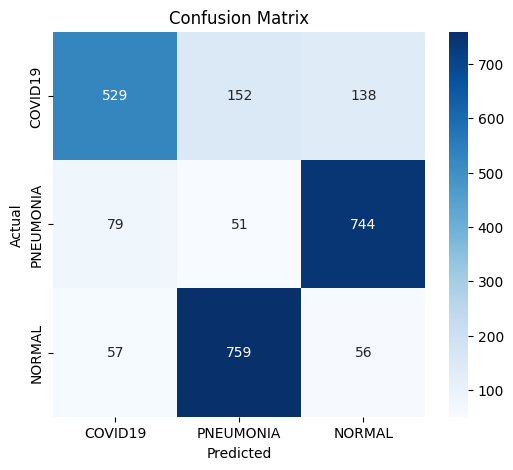

Classification Report:
               precision    recall  f1-score   support

     COVID19       0.80      0.65      0.71       819
   PNEUMONIA       0.05      0.06      0.06       874
      NORMAL       0.06      0.06      0.06       872

    accuracy                           0.25      2565
   macro avg       0.30      0.26      0.28      2565
weighted avg       0.29      0.25      0.27      2565



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert labels and predictions to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# 1 Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Ensemble Accuracy: {acc*100:.2f}%")

# 2 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset_224.classes, yticklabels=test_dataset_224.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3️ Classification Report (Precision, Recall, F1-score)
report = classification_report(all_labels, all_preds, target_names=test_dataset_224.classes)
print("Classification Report:\n", report)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming all_preds and all_labels are already collected
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Calculate specificity per class
specificity_per_class = []

for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

# Print specificity for each class
for idx, spec in enumerate(specificity_per_class):
    print(f"Specificity for class {idx} ({test_dataset_224.classes[idx]}): {spec:.4f}")


Confusion Matrix:
 [[529 152 138]
 [ 79  51 744]
 [ 57 759  56]]
Specificity for class 0 (COVID19): 0.9221
Specificity for class 1 (PNEUMONIA): 0.4613
Specificity for class 2 (NORMAL): 0.4790


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.preprocessing import label_binarize

all_labels_bin = label_binarize(all_labels, classes=[0,1,2])
all_probs = np.array(all_probs)

roc_auc = roc_auc_score(all_labels_bin, all_probs, average='macro', multi_class='ovr')
print(f"AUROC: {roc_auc:.4f}")

AUROC: 0.4440


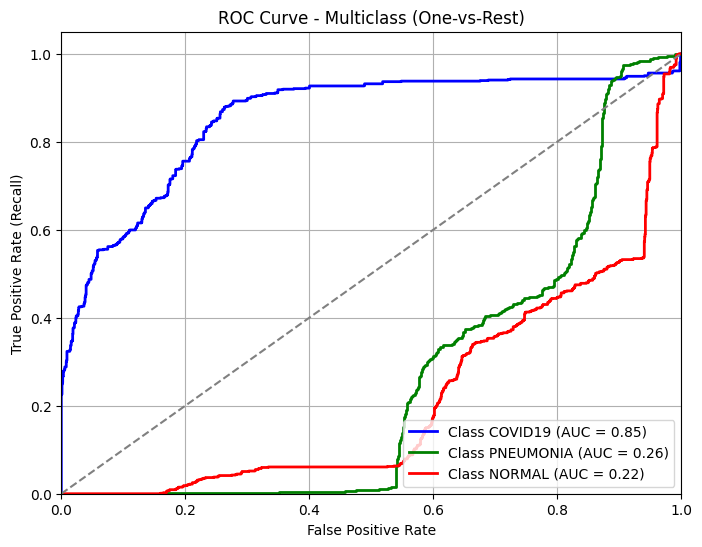

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))

colors = ['blue', 'green', 'red']
# Ensure all_labels_bin and all_probs are numpy arrays
all_labels_bin_np = np.array(all_labels_bin)
all_probs_np = np.array(all_probs)

for i in range(3):
    # Use numpy arrays for slicing
    fpr, tpr, _ = roc_curve(all_labels_bin_np[:, i], all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {test_dataset_224.classes[i]} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Multiclass (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()